# **Diffusion models from scratch, from a new theoretical perspective**

**Diffusion models trained by:**

1. Sampling $x_0 \sim K$ noise level $\sigma \sim [\sigma_{min},\sigma_{max}]$, noise $\epsilon \sim N(0, I)$
2. Generating noisy data $x_{\sigma} = x_0 + \sigma \epsilon$
3. Prediction $\epsilon$ (direction of noise) from $x_{\sigma}$ by minimizing squared loss

In [43]:
import math
from itertools import pairwise

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


In [54]:
class Schedule():
    def __init__(self, sigmas: torch.FloatTensor):
        self.sigmas = sigmas

    def __getitem__(self, i) -> torch.FloatTensor:
        return self.sigmas[i]
    
    def __len__(self) -> int:
        return len(self.sigmas)
    
    def sample_batch(self, x0: torch.FloatTensor) -> torch.FloatTensor:
        return self[torch.randint(len(self), (x0.shape[0],))].to(x0)

    # def sample_batch(self, x0:torch.FloatTensor) -> torch.FloatTensor:
    #     if type(x0) != torch.FloatTensor:
    #         x0 = torch.FloatTensor(x0)
    #     return self[torch.randint(len(self), (x0.shape[0],))].to(x0)

In [55]:
class ScheduleLogLinear(Schedule):
    def __init__(self,
                 N: int,
                 sigma_min: float = 0.02,
                 sigma_max: float = 10):
        
        super().__init__(torch.logspace(
            math.log10(sigma_min), 
            math.log10(sigma_max), N))

In [64]:
def generate_train_sample(
                        x0: torch.FloatTensor,
                        schedule: Schedule):
    # Ensure x0 is a tensor (unwrap it if DataLoader returns a list/tuple)
    if isinstance(x0, (list, tuple)):
        x0 = x0[0]  # Assuming the data is the first element

    sigma = schedule.sample_batch(x0)
    eps = torch.randn_like(x0)
    return sigma, eps

In [ ]:
def training_loop(
                loader: DataLoader,
                model: nn.Module,
                schedule: Schedule,
                epochs: int = 10000):
    
    optimizer = torch.optim.Adam(model.parameters())
    for _ in range(epochs):
        for x0 in loader:
            optimizer.zero_grad()
            sigma, eps = generate_train_sample(x0, schedule)
            print(f'sigma shape: {sigma.shape}')
            eps_hat = model(x0 + sigma * eps, sigma)
            loss = nn.MSELoss()(eps_hat, eps)
            optimizer.backward(loss)
            optimizer.step()



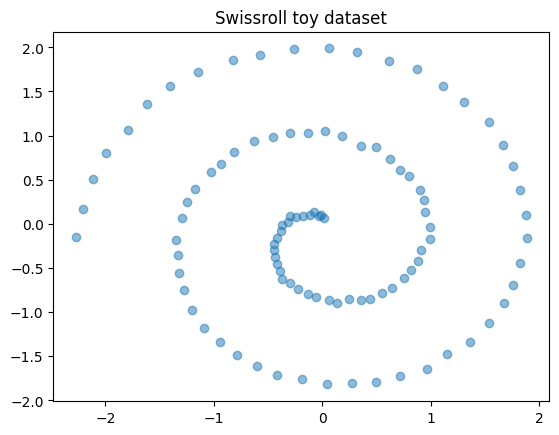

In [73]:
def swissroll(n_samples=1000, start=np.pi/2, stop=5*np.pi, noise=0.1):
    """Generates a 2D Swiss Roll (spiral)."""
    t = np.linspace(start, stop, n_samples)
    x = t * np.cos(t)
    y = t * np.sin(t)
    X = np.column_stack((x, y))
    X += noise * np.random.randn(*X.shape)  # Add noise
    return X

# Generate data
X = swissroll(n_samples=100, start=np.pi/2, stop=5*np.pi)

# Normalize (optional but recommended)
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Convert to PyTorch Dataset
dataset = TensorDataset(torch.from_numpy(X).float())
loader = DataLoader(dataset, batch_size=2048, shuffle=True)

# Visualize
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.title('Swissroll toy dataset')
plt.show()

For this simple dataset, we can implement the denoiser using a `multi-layer perceptron` (MLP)

In [74]:
def get_sigma_embeds(sigma):
    sigma = sigma.unsqueeze(1)
    return torch.cat([
        torch.sin(torch.log(sigma)/2),
        torch.cos(torch.log(sigma)/2)
        ])

In [75]:
class TimeInputMLP(nn.Module):
    def __init__(self, dim, hidden_dims):
        super().__init__()
        layers = []

        # for in_dim, out_dim in pairwise(())

In [76]:
class TimeInputMLP(nn.Module):
    def __init__(self, dim, hidden_dims):
        super().__init__()
        layers = []
        for in_dim, out_dim in pairwise((dim + 2,) + hidden_dims):
            layers.extend([nn.Linear(in_dim, out_dim), nn.GELU()])
        layers.append(nn.Linear(hidden_dims[-1], dim))
        self.net = nn.Sequential(*layers)
        self.input_dims = (dim,)

    def rand_input(self, batchsize):
        return torch.randn((batchsize,) + self.input_dims)

    def forward(self, x, sigma):
        sigma_embeds = get_sigma_embeds(sigma)         # shape: b x 2
        nn_input = torch.cat([x, sigma_embeds], dim=1) # shape: b x (dim + 2)
        return self.net(nn_input)

In [77]:
model = TimeInputMLP(dim=2, hidden_dims=(16,128,128,128,128,16))


In [78]:
schedule = ScheduleLogLinear(N=200, sigma_min=0.005, sigma_max=10)
trainer  = training_loop(loader, model, schedule, epochs=15000)
losses   = [ns.loss.item() for ns in trainer]

sigma: tensor([1.6791e-01, 5.3387e-02, 2.0324e-01, 4.8398e+00, 1.3352e-01, 1.2036e-02,
        2.8662e-01, 9.3657e-01, 1.1151e-02, 2.1116e-01, 4.5328e-01, 1.5556e-01,
        1.1906e-01, 2.2177e-02, 2.7588e-01, 8.2151e-03, 4.2452e-02, 1.8626e+00,
        9.0147e-01, 6.0863e+00, 1.5136e-02, 2.4870e-02, 4.3158e+00, 4.2452e-02,
        8.6769e-01, 9.5712e-03, 8.5832e+00, 1.6162e-01, 1.8322e-02, 9.2125e-03,
        2.4870e-02, 1.0331e-02, 1.1460e-01, 1.8829e-01, 2.7588e-01, 2.6844e-02,
        3.5072e-02, 2.8975e-02, 2.1116e-01, 1.2036e-02, 8.5350e-03, 4.8926e-01,
        4.8926e-01, 2.2792e-01, 8.5832e+00, 1.4569e-02, 2.4601e-01, 3.0603e+00,
        5.9868e-02, 1.1778e+00, 7.3257e-03, 8.2151e-03, 2.9778e-01, 7.4475e-01,
        2.8975e-02, 1.2992e-02, 1.9351e+00, 2.0888e+00, 2.0105e+00, 5.9222e-01,
        1.6610e+00, 3.2142e-01, 4.1541e+00, 5.7625e-02, 2.3679e-01, 8.8673e-03,
        2.9456e+00, 5.9868e-02, 1.8124e-01, 3.0937e-01, 2.4336e+00, 1.0733e-02,
        1.3352e-01, 1.1778e+00, 1

RuntimeError: The size of tensor a (100) must match the size of tensor b (2) at non-singleton dimension 1

In [ ]:
a = [1,3,4,65,23,4]
a = torch.FloatTensor(a)
a

tensor([ 1.,  3.,  4., 65., 23.,  4.])